In [1]:
import pandas as pd
import numpy as np
import argparse

import pickle as pkl


from functools import reduce

In [2]:
def year_binner(year,val=10):
    return year - year%val

In [3]:
parser = argparse.ArgumentParser(description='Compute features from sparse dataset')

parser.add_argument('--temporal',  type=int,
                    help='Value to bin the temporal information: 0 (remove temporal information), 1 (no binning), 10 (binning to decades), 20 (binning each 20 years) or 50 (binning each 50 years)')

parser.add_argument('--cutoff', type=int, default=50,
                    help='Cut-off frequency for each compound per time period : none (0), 20, 50 and 100')

parser.add_argument('--contextual', action='store_true',
                    help='Is the model contextual')
parser.add_argument('--inputdir',type=str,
                    help='Provide directory where features are located')
parser.add_argument('--outputdir',type=str,
                    help='Where should the output be stored?')

parser.add_argument('--input_format',type=str,default='csv',choices=['csv','pkl'],
                    help='In what format are the input files : csv or pkl')
parser.add_argument('--save_format', type=str,default='pkl',choices=['pkl','csv'],
                    help='In what format should the reduced datasets be saved : csv or pkl')

args = parser.parse_args('--input_format csv --inputdir ../Compounding/coha_compounds/ --contextual --temporal 10 --cutoff 10 --outputdir ../Compounding/coha_compounds/'.split())

In [4]:
print(f'Cutoff: {args.cutoff}')
print(f'Time span:  {args.temporal}')
temp_cutoff_str=str(args.temporal)+'_'+str(args.cutoff)

Cutoff: 10
Time span:  10


In [5]:
if args.contextual:
    print("CompoundCentric Model")
    print("Loading the constituent and compound vector datasets")

    if args.input_format=="csv":
        compounds=pd.read_csv(args.inputdir+"/compounds.csv",sep="\t")
    elif args.input=="pkl":
        compounds=pd.read_pickle(args.inputdir+"/compounds.pkl")
        compounds.reset_index(inplace=True)
    compounds.columns=['modifier','head','context','year','count']

    if args.temporal==0:
        print('No temporal information is stored')

        compounds=compounds.loc[compounds.groupby(['head','modifier'])['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['head','modifier','context'])['count'].sum().to_frame()
        compounds.reset_index(inplace=True)

    else:
        print(f'Temporal information is stored with intervals {args.temporal}')
        compounds.year=compounds.year.astype("int32")
        compounds.query('1800 <= year <= 2010',inplace=True)
        compounds['time']=year_binner(compounds['year'].values,args.temporal)
        compounds=compounds.loc[compounds.groupby(['head','modifier','time'])['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['head','modifier','time','context'])['count'].sum().to_frame()
        compounds.reset_index(inplace=True)


    if args.input_format=="csv":
        modifiers=pd.read_csv(args.inputdir+"/modifiers.csv",sep="\t")
    elif args.input=="pkl":
        modifiers=pd.read_pickle(args.inputdir+"/modifiers.pkl")
        modifiers.reset_index(inplace=True)


    modifiers.columns=['modifier','context','year','count']
    
    if args.temporal==0:
        modifiers=modifiers.loc[modifiers.groupby(['modifier'])['count'].transform('sum').gt(args.cutoff)]
        modifiers=modifiers.groupby(['modifier','context'])['count'].sum().to_frame()
        modifiers.reset_index(inplace=True)
    else:
        modifiers.year=modifiers.year.astype("int32")
        modifiers.query('1800 <= year <= 2010',inplace=True)        
        modifiers['time']=year_binner(modifiers['year'].values,args.temporal)
        modifiers=modifiers.loc[modifiers.groupby(['modifier','time'])['count'].transform('sum').gt(args.cutoff)]
        modifiers=modifiers.groupby(['modifier','time','context'])['count'].sum().to_frame()
        modifiers.reset_index(inplace=True)
        

    if args.input_format=="csv":
        heads=pd.read_csv(args.inputdir+"/heads.csv",sep="\t")
    elif args.input_format=="pkl":
        heads=pd.read_pickle(args.inputdir+"/heads.pkl")
        heads.reset_index(inplace=True)


    heads.columns=['head','context','year','count']

    if args.temporal==0:
        heads=heads.loc[heads.groupby(['head'])['count'].transform('sum').gt(args.cutoff)]
        heads=heads.groupby(['head','context'])['count'].sum().to_frame()
        heads.reset_index(inplace=True)

    else:
        heads.year=heads.year.astype("int32")
        heads.query('1800 <= year <= 2010',inplace=True)
        heads['time']=year_binner(heads['year'].values,args.temporal)
        heads=heads.loc[heads.groupby(['head','time'])['count'].transform('sum').gt(args.cutoff)]
        heads=heads.groupby(['head','time','context'])['count'].sum().to_frame()
        heads.reset_index(inplace=True)


else:
    print("CompoundAgnostic Model")
    wordlist = pkl.load( open( "./data/coha_wordlist.pkl", "rb" ) )
    
    if args.input_format=="csv":
        compounds=pd.read_csv(args.inputdir+"/phrases.csv",sep="\t")
    elif args.input_format=="pkl":
        compounds=pd.read_pickle(args.inputdir+"/phrases.pkl")
        compounds.reset_index(inplace=True)

    compounds.columns=['modifier','head','context','year','count']

    if args.temporal==0:
        print('No temporal information is stored')

        compounds=compounds.loc[compounds.groupby(['head','modifier'])['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['head','modifier','context'])['count'].sum().to_frame()
        compounds.reset_index(inplace=True)

    else:
        print(f'Temporal information is stored with intervals {args.temporal}')
        compounds.year=compounds.year.astype("int32")
        compounds.query('1800 <= year <= 2010',inplace=True)
        compounds['time']=year_binner(compounds['year'].values,args.temporal)
        compounds=compounds.loc[compounds.groupby(['head','modifier','time'])['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['head','modifier','time','context'])['count'].sum().to_frame()
        compounds.reset_index(inplace=True)


    if args.input_format=="csv":
        constituents=pd.read_csv(args.inputdir+"/words.csv",sep="\t")
    elif args.input=="pkl":
        constituents=pd.read_pickle(args.inputdir+"/words.pkl")
        constituents.reset_index(inplace=True)

    constituents.columns=['constituent','context','year','count']
    constituents.query('constituent in @wordlist',inplace=True)
    
    if args.temporal==0:
        constituents=constituents.loc[constituents.groupby(['constituent'])['count'].transform('sum').gt(args.cutoff)]
        constituents=constituents.groupby(['constituent','context'])['count'].sum().to_frame()
        constituents.reset_index(inplace=True)
        
        modifiers=constituents.copy()
        modifiers.columns=['modifier','context','count']
        heads=constituents.copy()
        heads.columns=['head','context','count']
    else:
        constituents.year=constituents.year.astype("int32")
        constituents.query('1800 <= year <= 2010',inplace=True)
        constituents['time']=year_binner(constituents['year'].values,args.temporal)
        constituents=constituents.loc[constituents.groupby(['constituent','time'])['count'].transform('sum').gt(args.cutoff)]
        constituents=constituents.groupby(['constituent','time','context'])['count'].sum().to_frame()
        constituents.reset_index(inplace=True)
        
        modifiers=constituents.copy()
        modifiers.columns=['modifier','time','context','count']
        heads=constituents.copy()
        heads.columns=['head','time','context','count']

CompoundCentric Model
Loading the constituent and compound vector datasets
Temporal information is stored with intervals 10


In [6]:
if args.temporal==0:
    all_comps=compounds[['modifier','head']]
    all_comps.drop_duplicates(inplace=True)
    mod_prod=all_comps.groupby(['modifier']).size().to_frame()
    mod_prod.columns=['mod_prod']
    mod_prod['N']=mod_prod['mod_prod'].sum()
    mod_prod['mod_family_size']=-np.log2((mod_prod.mod_prod+1)/(mod_prod.N-mod_prod.mod_prod+1))
    
    head_prod=all_comps.groupby(['head']).size().to_frame()
    head_prod.columns=['head_prod']
    head_prod['N']=head_prod['head_prod'].sum()
    head_prod['head_family_size']=-np.log2((head_prod.head_prod+1)/(head_prod.N-head_prod.head_prod+1))
    
    prod1=pd.merge(all_comps,mod_prod.reset_index(),how='left',on=['modifier'])
    productivity=pd.merge(prod1,head_prod.reset_index(),how='left',on=['head'])
    productivity.set_index(['modifier','head'],inplace=True)
    productivity.drop(['N_x','N_y'],axis=1,inplace=True)
else:

    all_comps=compounds[['modifier','head','time']]
    all_comps.drop_duplicates(inplace=True)
    compound_counts=all_comps.groupby(['time']).size().to_frame()
    compound_counts.columns=['N']    
    
    mod_prod=all_comps.groupby(['modifier','time']).size().to_frame()
    mod_prod.columns=['mod_prod']
    mod_prod=pd.merge(mod_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
    mod_prod['mod_family_size']=-np.log2((mod_prod.mod_prod+1)/(mod_prod.N-mod_prod.mod_prod+1))
    
    
    head_prod=all_comps.groupby(['head','time']).size().to_frame()
    head_prod.columns=['head_prod']
    head_prod=pd.merge(head_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
    head_prod['head_family_size']=-np.log2((head_prod.head_prod+1)/(head_prod.N-head_prod.head_prod+1))
    
    prod1=pd.merge(all_comps,mod_prod,how='left',on=['modifier','time'])
    productivity=pd.merge(prod1,head_prod,how='left',on=['head','time'])
    productivity.set_index(['modifier','head','time'],inplace=True)
    productivity.drop(['N_x','N_y'],axis=1,inplace=True)
productivity

mod_prod  mod_family_size  head_prod  \
modifier        head      time                                         
death_noun      --_noun   1990         4            7.459         12   
editor_noun     --_noun   1990         1            8.786         12   
                          2000         1            8.613          4   
government_noun --_noun   1860         2            3.700          1   
hand_noun       --_noun   1980         1            8.660          7   
...                                  ...              ...        ...   
lemon_noun      zest_noun 2000         3            7.609          1   
canal_noun      zone_noun 1960         1            7.728          1   
end_noun        zone_noun 2000         1            8.613          2   
twilight_noun   zone_noun 1990         1            8.786          1   
                          2000         1            8.613          2   

                                head_family_size  
modifier        head      time                    
death_noun      --_noun   1990             6.068  
editor_noun     --_noun   1990             6.068  
                          2000             7.285  
government_noun --_noun   1860             4.322  
hand_noun       --_noun   1980             6.649  
...                                          ...  
lemon_noun      zest_noun 2000             8.613  
canal_noun      zone_noun 1960             7.728  
end_noun        zone_noun 2000             8.026  
twilight_noun   zone_noun 1990             8.786  
                          2000             8.026  

[5395 rows x 4 columns]

In [7]:
if args.temporal!=0:
    
    compound_decade_counts=compounds.groupby('time').sum().sum(axis=1).to_frame()
    compound_decade_counts.columns=['N']

    XY=compounds.groupby(['modifier','head','time']).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier','time']).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head','time']).sum().sum(axis=1).to_frame()


else:
    XY=compounds.groupby(['modifier','head']).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier']).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head']).sum().sum(axis=1).to_frame()

XY.columns=['a']

X_star.columns=['x_star']
Y_star.columns=['star_y']

if args.temporal!=0:
 
    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])
else:
    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head'])    

information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']

if args.temporal!=0:
    information_feat=pd.merge(information_feat,compound_decade_counts.reset_index(),on=['time'])

else: 
    information_feat['N']=compounds['count'].sum()
    

information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']

if args.temporal!=0:

    information_feat.set_index(['modifier','head','time'],inplace=True)
else:
    information_feat.set_index(['modifier','head'],inplace=True)
    
information_feat['log_ratio']=2*(information_feat['a']*np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']+1))+\
information_feat['b']*np.log2((information_feat['b']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y_bar']+1))+\
information_feat['c']*np.log2((information_feat['c']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y']+1))+\
information_feat['d']*np.log2((information_feat['d']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y_bar']+1)))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat

,,,log_ratio,ppmi,local_mi
modifier,head,time,,,
abortion_noun,reform_noun,1970,170.594,7.006,84.070
campaign_noun,reform_noun,1970,112.410,6.006,66.064
tax_noun,reform_noun,1970,239.755,5.213,145.971
welfare_noun,reform_noun,1970,529.500,7.006,252.210
academy_noun,award_noun,1970,271.098,9.864,118.366
...,...,...,...,...,...
paper_noun,money_noun,1840,87.691,2.371,28.454
post_noun,office_noun,1840,120.528,1.311,32.782
state_noun,house_noun,1840,91.680,2.256,29.322


a the frequency of node - collocate pairs
b number of instances where the node does not co-occur with the collocate
c number of instances where the collocate does not co-occur with the node
b the number of words in the corpus minus the number of occurrences of the node and the collocate

2*(information_feat['a']*np.log2(information_feat['a']+1)+\
  information_feat['b']*np.log2(information_feat['b']+1)+\
  information_feat['c']*np.log2(information_feat['c']+1)+\
  information_feat['d']*np.log2(information_feat['d']+1)-\
  (information_feat['a']+information_feat['b'])*np.log2(information_feat['a']+information_feat['b']+1)-\
  (information_feat['a']+information_feat['c'])*np.log2(information_feat['a']+information_feat['c']+1)-\
  (information_feat['b']+information_feat['d'])*np.log2(information_feat['b']+information_feat['d']+1)-\
  (information_feat['c']+information_feat['d'])*np.log2(information_feat['c']+information_feat['d']+1)+\
  (information_feat['a']+information_feat['b']+information_feat['c']+information_feat['d'])*\
   np.log2(information_feat['a']+information_feat['b']+information_feat['c']+information_feat['d']+1))

2*( a*log(a) + b*log(b) + c*log(c) + d*log(d)
- (a+b)*log(a+b) - (a+c)*log(a+c)
- (b+d)*log(b+d) - (c+d)*log(c+d)
+ (a+b+c+d)*log(a+b+c+d))

In [8]:
if args.temporal==0:

    compound_denom=compounds.groupby(['modifier','head'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
    compound_denom.columns=['compound_denom']
    
    modifier_denom=modifiers.groupby(['modifier'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
    modifier_denom.columns=['modifier_denom']

    head_denom=heads.groupby(['head'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
    head_denom.columns=['head_denom']
else:

    compound_denom=compounds.groupby(['modifier','head','time'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
    compound_denom.columns=['compound_denom']

    modifier_denom=modifiers.groupby(['modifier','time'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
    modifier_denom.columns=['modifier_denom']
    
    head_denom=heads.groupby(['head','time'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
    head_denom.columns=['head_denom']

mod_cols=modifiers.columns.tolist()
mod_cols[-1]="mod_count"
modifiers.columns=mod_cols



head_cols=heads.columns.tolist()
head_cols[-1]="head_count"
heads.columns=head_cols

#compounds.drop(['comp_count'],axis=1,inplace=True)
comp_cols=compounds.columns.tolist()
comp_cols[-1]="comp_count"
compounds.columns=comp_cols

In [9]:
if args.temporal==0:
    
    compound_modifier_sim=pd.merge(compounds,modifiers,on=["modifier","context"])
    compound_modifier_sim['numerator']=compound_modifier_sim['comp_count']*compound_modifier_sim['mod_count']
    compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head'])['numerator'].sum().to_frame()
    compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head"])
    compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier'])
    compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
    compound_modifier_sim.set_index(['modifier','head'],inplace=True)
    compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
else:
    mod_cols=modifiers.columns.tolist()
    mod_cols[-1]="mod_count"
    modifiers.columns=mod_cols
    #compounds.drop(['comp_count'],axis=1,inplace=True)
    comp_cols=compounds.columns.tolist()
    comp_cols[-1]="comp_count"
    compounds.columns=comp_cols
    compound_modifier_sim=pd.merge(compounds,modifiers,on=["modifier","context",'time'])
    compound_modifier_sim['numerator']=compound_modifier_sim['comp_count']*compound_modifier_sim['mod_count']
    compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head','time'])['numerator'].sum().to_frame()
    compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
    compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier','time'])
    compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
    compound_modifier_sim.set_index(['modifier','head','time'],inplace=True)
    compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)


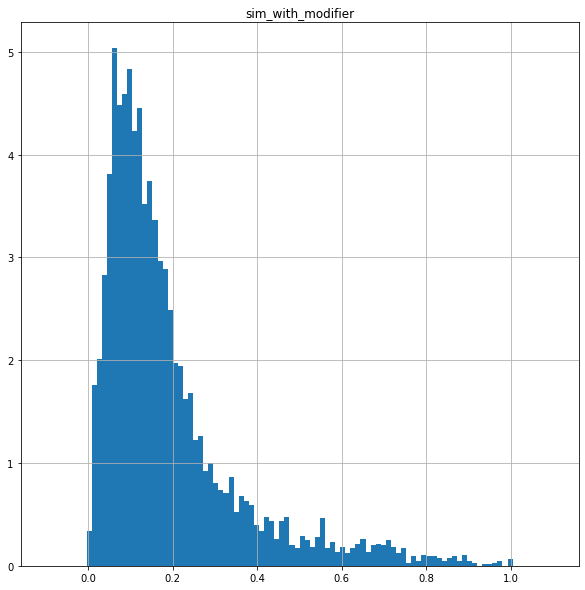

In [10]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [11]:
compound_modifier_sim.sim_with_modifier.describe()

count   5,395.000
mean        0.190
std         0.166
min         0.004
25%         0.081
50%         0.139
75%         0.233
max         1.000
Name: sim_with_modifier, dtype: float64

In [12]:
if args.temporal==0:
    
    compound_head_sim=pd.merge(compounds,heads,on=["head","context"])
    compound_head_sim['numerator']=compound_head_sim['comp_count']*compound_head_sim['head_count']
    compound_head_sim=compound_head_sim.groupby(['modifier','head'])['numerator'].sum().to_frame()
    compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head"])
    compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head'])
    compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
    compound_head_sim.set_index(['modifier','head'],inplace=True)
    compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
else:
    compound_head_sim=pd.merge(compounds,heads,on=["head","context",'time'])
    compound_head_sim['numerator']=compound_head_sim['comp_count']*compound_head_sim['head_count']
    compound_head_sim=compound_head_sim.groupby(['modifier','head','time'])['numerator'].sum().to_frame()
    compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
    compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head','time'])
    compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
    compound_head_sim.set_index(['modifier','head','time'],inplace=True)
    compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
compound_head_sim

head_denom  sim_with_head
modifier      head          time                           
abortion_noun reform_noun   1970      62.330          0.074
campaign_noun reform_noun   1970      62.330          0.106
tax_noun      reform_noun   1970      62.330          0.421
welfare_noun  reform_noun   1970      62.330          0.298
academy_noun  award_noun    1950      23.022          0.381
...                                      ...            ...
yankee_noun   stadium_noun  1980      31.448          0.152
                            2000      39.370          0.160
youth_noun    soccer_noun   2000      17.349          0.377
              violence_noun 1990      24.228          0.165
zebra_noun    mussel_noun   1990      29.766          0.225

[5395 rows x 2 columns]

In [13]:
compound_head_sim.sim_with_head.describe()

count   5,395.000
mean        0.210
std         0.173
min         0.005
25%         0.094
50%         0.155
75%         0.262
max         1.000
Name: sim_with_head, dtype: float64

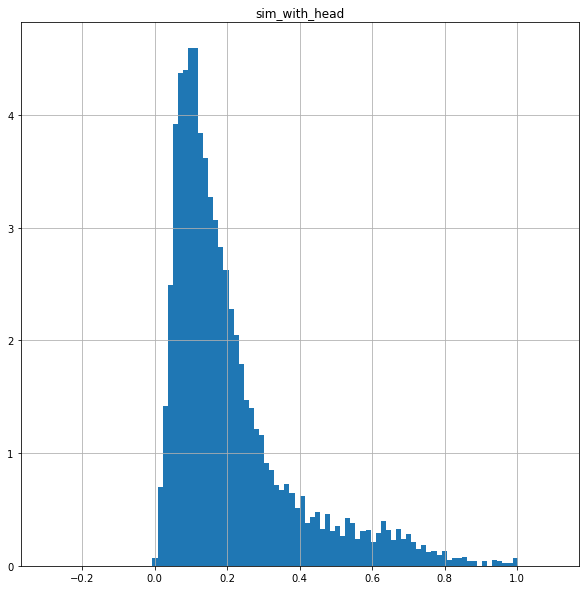

In [14]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [15]:
if args.temporal==0:
    
    constituent_sim=pd.merge(heads,compounds,on=["head","context"])
    #constituent_sim.drop('comp_count',axis=1,inplace=True)
    constituent_sim=pd.merge(constituent_sim,modifiers,on=["modifier","context"])
    constituent_sim['numerator']=constituent_sim['head_count']*constituent_sim['mod_count']
    constituent_sim=constituent_sim.groupby(['modifier','head'])['numerator'].sum().to_frame()
    constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head"])
    constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier"])
    constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
    constituent_sim.set_index(['modifier','head'],inplace=True)
    constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)
else:
    constituent_sim=pd.merge(heads,compounds,on=["head","context","time"])
    #constituent_sim.drop('comp_count',axis=1,inplace=True)
    constituent_sim=pd.merge(constituent_sim,modifiers,on=["modifier","context","time"])
    constituent_sim['numerator']=constituent_sim['head_count']*constituent_sim['mod_count']
    constituent_sim=constituent_sim.groupby(['modifier','head','time'])['numerator'].sum().to_frame()
    constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head","time"])
    constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier","time"])
    constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
    constituent_sim.set_index(['modifier','head','time'],inplace=True)
    constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)

sim_bw_constituents
modifier      head                time                     
abortion_noun reform_noun         1970                0.023
campaign_noun reform_noun         1970                0.015
              fund_noun           1970                0.021
tax_noun      reform_noun         1970                0.154
              policy_noun         1970                0.003
...                                                     ...
work_noun     simplification_noun 1960                0.043
yankee_noun   stadium_noun        1970                0.032
                                  1980                0.047
                                  2000                0.026
zebra_noun    mussel_noun         1990                0.051

[5395 rows x 1 columns]

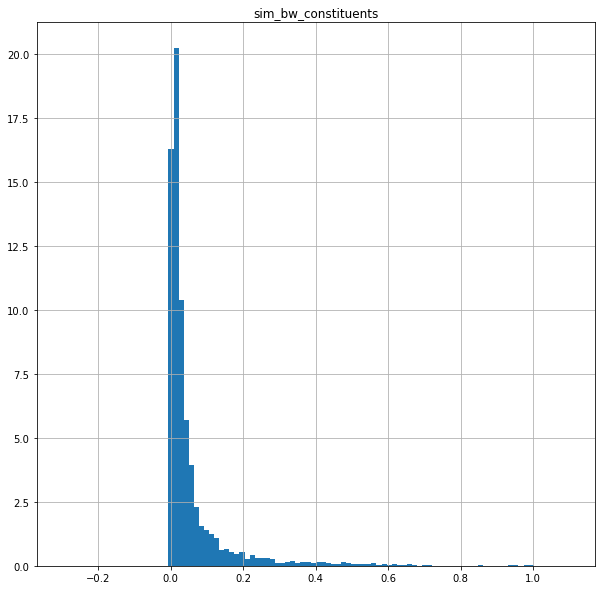

In [16]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [18]:
dfs = [constituent_sim, compound_head_sim, compound_modifier_sim, information_feat,productivity]
compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)



if args.temporal!=0:
    compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])

    compounds_final.fillna(0,inplace=True)
    #compounds_final -= compounds_final.min()
    #compounds_final /= compounds_final.max()
    compounds_final_1=compounds_final.columns.get_level_values(0)
    compounds_final_2=compounds_final.columns.get_level_values(1)

    cur_year=0
    new_columns=[]
    for year in compounds_final_2:
        new_columns.append(str(year)+"_"+compounds_final_1[cur_year])
        cur_year+=1
    compounds_final.columns=new_columns


else:
    #compounds_final = reduce(lambda left,right: pd.merge(left,right,on=['modifier','head']), dfs)
    #compounds_final.drop(['head_denom','modifier_denom'],axis=1,inplace=True)
    compounds_final.fillna(0,inplace=True)
    #compounds_final -= compounds_final.min()
    #compounds_final /= compounds_final.max()
compounds_final

1830_head_denom  1840_head_denom  \
modifier           head                                               
abortion_noun      reform_noun               0.000            0.000   
academy_noun       award_noun                0.000            0.000   
accreditation_noun committee_noun            0.000            0.000   
achievement_noun   award_noun                0.000            0.000   
acid_noun          rain_noun                 0.000            0.000   
...                                            ...              ...   
youth_noun         law_noun                  0.000            0.000   
                   service_noun              0.000            0.000   
                   soccer_noun               0.000            0.000   
                   violence_noun             0.000            0.000   
zebra_noun         mussel_noun               0.000            0.000   

                                   1850_head_denom  1860_head_denom  \
modifier           head                                               
abortion_noun      reform_noun               0.000            0.000   
academy_noun       award_noun                0.000            0.000   
accreditation_noun committee_noun            0.000            0.000   
achievement_noun   award_noun                0.000            0.000   
acid_noun          rain_noun                 0.000            0.000   
...                                            ...              ...   
youth_noun         law_noun                  0.000            0.000   
                   service_noun              0.000            0.000   
                   soccer_noun               0.000            0.000   
                   violence_noun             0.000            0.000   
zebra_noun         mussel_noun               0.000            0.000   

                                   1870_head_denom  1880_head_denom  \
modifier           head                                               
abortion_noun      reform_noun               0.000            0.000   
academy_noun       award_noun                0.000            0.000   
accreditation_noun committee_noun            0.000            0.000   
achievement_noun   award_noun                0.000            0.000   
acid_noun          rain_noun                 0.000            0.000   
...                                            ...              ...   
youth_noun         law_noun                  0.000            0.000   
                   service_noun              0.000            0.000   
                   soccer_noun               0.000            0.000   
                   violence_noun             0.000            0.000   
zebra_noun         mussel_noun               0.000            0.000   

                                   1890_head_denom  1900_head_denom  \
modifier           head                                               
abortion_noun      reform_noun               0.000            0.000   
academy_noun       award_noun                0.000            0.000   
accreditation_noun committee_noun            0.000            0.000   
achievement_noun   award_noun                0.000            0.000   
acid_noun          rain_noun                 0.000            0.000   
...                                            ...              ...   
youth_noun         law_noun                  0.000            0.000   
                   service_noun              0.000            0.000   
                   soccer_noun               0.000            0.000   
                   violence_noun             0.000            0.000   
zebra_noun         mussel_noun               0.000            0.000   

                                   1910_head_denom  1920_head_denom  ...  \
modifier           head                                              ...   
abortion_noun      reform_noun               0.000            0.000  ...   
academy_noun       award_noun                0.000            0.000  ...   
accreditation_noun committee_noun  

In [20]:
compounds_final.to_csv("data/features_unnormalized.csv")

In [18]:
compounds_final[['2000_head_prod','2000_head_family_size']]

2000_head_prod  2000_head_family_size
modifier           head                                                 
abortion_noun      reform_noun              0.000                  0.000
academy_noun       award_noun               0.125                  0.932
accreditation_noun committee_noun           0.000                  0.000
achievement_noun   award_noun               0.125                  0.932
acid_noun          rain_noun                0.062                  1.000
...                                           ...                    ...
youth_noun         law_noun                 0.312                  0.815
                   service_noun             0.000                  0.000
                   soccer_noun              0.062                  1.000
                   violence_noun            0.000                  0.000
zebra_noun         mussel_noun              0.000                  0.000

[2622 rows x 2 columns]

In [22]:
productivity[['head_prod','head_family_size']].xs(['youth_noun','soccer_noun'])

/home/users0/pageljs/dh/build/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2895: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


,head_prod,head_family_size
time,,
2000,1,8.613
